In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import kss
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from sklearn.cluster import KMeans

In [2]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, seq_len, d_model, n, device):
        
        super(PositionalEncoding, self).__init__() # nn.Module 초기화
        
        # encoding : (seq_len, d_model)
        self.encoding = torch.zeros(seq_len, d_model, device=device)
        self.encoding.requires_grad = False
        
        # (seq_len, )
        pos = torch.arange(0, seq_len, device=device)
        # (seq_len, 1)         
        pos = pos.float().unsqueeze(dim=1) # int64 -> float32 (없어도 되긴 함)
        
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        self.encoding[:, ::2] = torch.sin(pos / (n ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (n ** (_2i / d_model)))
        
        
    def forward(self, x):
        # x.shape : (batch, seq_len) or (batch, seq_len, d_model)
        seq_len = x.size()[1] 
        # return : (seq_len, d_model)
        # return matrix will be added to x by broadcasting
        return self.encoding[:seq_len, :]
    
    
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-Medium", do_lower_case=False)
model = AutoModel.from_pretrained("snunlp/KR-Medium")

In [4]:
df = pd.read_json('totalNews.json')
df.dropna(subset='sliced', inplace=True)
df.reset_index(drop=True, inplace=True)
df['embedding'] = None
df.head(5)

,작성일,작성자,제목,내용,sliced,embedding
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,None
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...",None
2,2023/01/29,SBS,[스프] 빌라왕은 범죄 왕국의 말단에 불과하다…전세사기의 모든 것,[몰아보기] '전세사기 배후 추적단' 이른바 '빌라왕'은 전세사기 범죄 생태계의 꼬...,[[몰아보기] '전세사기 배후 추적단' 이른바 '빌라왕'은 전세사기 범죄 생태계의 ...,None
3,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,None
4,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...",None


# Document Embedding

In [ ]:
for idx in range(len(df)) :
    title = tokenizer(df.iloc[idx,2], padding='longest', return_tensors='pt') # 제목 토큰화
    tokenized = tokenizer(df.iloc[idx,4], padding='longest', return_tensors='pt') # 내용 토큰화됨
    try :
        title = model(**title).pooler_output # 제목 embedding
        tokenized = model(**tokenized).pooler_output # 내용 각 문장들 embedding
        # 제목 semantic을 내용에 발라주기
        for _ in range(6) :
            tokenized = (F.softmax(F.cosine_similarity(title, tokenized), dim=0).reshape(-1,1) + 1) * tokenized
        # 문장 positional encoding
        seq_len = len(tokenized)
        pos_encoder = PositionalEncoding(seq_len=seq_len, d_model=768, n=10000, device='cpu')
        tokenized += pos_encoder(tokenized)
        # document embedding vector 준비
        dummy = torch.rand((768)).reshape(1,-1)
        total = torch.cat([dummy, title, tokenized])
        # document embedding
        for _ in range(6) :
            cosine_similarities = F.cosine_similarity(total.unsqueeze(1), total.unsqueeze(0), dim=2)
            attention_weights = F.softmax(cosine_similarities, dim=1)
            total = torch.matmul(attention_weights, total)
        df.at[idx,'embedding'] = total[0].tolist()
    except :
        print(idx, 'error')

In [9]:
df.dropna(subset='embedding', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,작성일,작성자,제목,내용,sliced,embedding
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,"[0.2230222374200821, -0.15853027999401093, 0.1..."
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...","[0.14549793303012848, 0.01735503412783146, 0.0..."
2,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,"[0.1846492439508438, -0.07732275128364563, 0.1..."
3,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...","[0.20137961208820343, -0.2160901576280594, -0...."
4,2023/01/18,아시아경제,[전세사기 실태추적]⑨형제가 피해자…인천 미추홀구 '나홀로아파트' 전세사기 주의보,도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자 ...,[도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자...,"[0.07882390916347504, -0.029544647783041, -0.0..."
...,...,...,...,...,...,...
23755,2023/04/25,머니투데이,머니투데이 오프라인 헤드라인-25일,"[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 주...","[[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 ...","[1.1439098119735718, -0.2594847083091736, 0.26..."
23756,2023/04/25,조선일보,“보수는 꼬리라도 자르는데 진보는 옹호하거나 뭉갠다”,한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59)...,[한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59...,"[0.2504984438419342, -0.13904313743114471, -0...."
23757,2023/04/25,SBS,클로징,<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다....,[<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다...,"[0.5075507164001465, -0.041939862072467804, -0..."
23758,2023/04/25,YTN,"행안위, '지방세보다 보증금 먼저 변제' 법안 논의","국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 전...","[국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 ...","[0.3680371344089508, -0.1718945950269699, -0.0..."


In [12]:
df.to_json('beta4.json')

In [13]:
pd.read_json('beta4.json')

,작성일,작성자,제목,내용,sliced,embedding
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,"[0.22302223740000002, -0.15853028, 0.115741297..."
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...","[0.145497933, 0.0173550341, 0.0550449751000000..."
2,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,"[0.18464924400000002, -0.0773227513, 0.1242663..."
3,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...","[0.2013796121, -0.2160901576, -0.0808888301, -..."
4,2023/01/18,아시아경제,[전세사기 실태추적]⑨형제가 피해자…인천 미추홀구 '나홀로아파트' 전세사기 주의보,도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자 ...,[도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자...,"[0.0788239092, -0.0295446478, -0.0511430353, -..."
...,...,...,...,...,...,...
23755,2023/04/25,머니투데이,머니투데이 오프라인 헤드라인-25일,"[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 주...","[[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 ...","[1.143909812, -0.25948470830000003, 0.26722675..."
23756,2023/04/25,조선일보,“보수는 꼬리라도 자르는데 진보는 옹호하거나 뭉갠다”,한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59)...,[한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59...,"[0.2504984438, -0.13904313740000002, -0.282626..."
23757,2023/04/25,SBS,클로징,<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다....,[<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다...,"[0.5075507164, -0.0419398621, -0.0113872681, -..."
23758,2023/04/25,YTN,"행안위, '지방세보다 보증금 먼저 변제' 법안 논의","국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 전...","[국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 ...","[0.3680371344, -0.171894595, -0.0917221755, -0..."


# 임시 전처리

In [606]:
idx

12459

In [607]:
df.iloc[idx,4]

['▲ 경향신문 = 윤 대통령 \'도어스테핑\' 잠정중단, 소통 노력 강화돼야 "개헌 조기 발의" 기시다, 아시아인 고통 외면할 건가 검찰총장 인선절차 시작, 늦은 만큼 제대로 된 후보자 찾길 ▲ 국민일보 = 중단된 도어스테핑, 꼼꼼히 정비하고 신속히 재개해야 정부 첫 업무보고…위기 극복과 민생 안정에 명운 걸라 서민 피눈물 흘리게 하는 전세사기, 이참에 뿌리 뽑도록 ▲ 서울신문 = 尹·여당 지지율 동반하락, 민심의 준엄한 경고다 기업에 대한 경제 형벌규정 합리화 시급하다 대통령과 공공기관장 \'임기 일치법\' 서둘러라 ▲ 세계일보 = 尹·與 지지율 동반 급락, 비상한 각오로 심기일전하라 일본 우경화 우려 낳는 자민당의 참의원 선거 압승 납득 안 되는 강제북송 이유와 과정, 진상 밝혀 책임 물어야 ▲ 아시아투데이 = 대통령-기관장 임기 일치제, 적극 추진하길 인플레 따른 \'부당한\' 세 부담 증가, 조정해야 ▲ 조선일보 = 尹 \'출근길 회견\' 잠정 중단, 달라진 모습으로 돌아와야 귀순 의향서 쓴 어민 북송해 놓고 국민 속여 온 文 정부 아베 전 총리 사망으로 강화된 일본의 \'평화 헌법\' 개정 움직임 ▲ 중앙일보 = 코로나 재확산, 지난 정부의 실기 반복 말아야 늦었지만 \'정치 중립적 검찰총장\' 발굴하길 ▲ 한겨레 = 윤 대통령 출근길 문답 중단, 소통 내용·인식 바뀌어야 공공기관장 임기 특별법, \'조건\' 걸지 말고 머리 맞대라 아베 사망·개헌세력 압승, 갈림길에 선 한일관계 ▲ 한국일보 = 잠정 중단된 도어스테핑, 시행착오 보완 계기로 권성동 대행체제 뜻 모은 與, 분란 접고 민생 챙겨라 지각 구성 검찰총장 추천위, 중립적 후보 찾아야 ▲ 디지털타임스 = 개헌 가능해진 일본…급격한 군사대국·우경화 경계한다 이준석, 분하더라도 `權직대체제` 의총 추인 일단 수용해야 ▲ 매일경제 = 툭하면 CEO 처벌하는 反기업법 정부 개선방향 옳다 2030부산엑스포 유치, 민관의 하나된 힘 보여줄 때 탈북어민 자필귀순서 받고 "죽더라도 北간다 했다" 왜곡은 뭔가

In [570]:
df.iloc[idx,4].pop(3)

'윤 청장은 최근 코로나19에 확진된 중국인이 탈주하는 사태의 후속조치와 관련 "보건복지부와 질병관리청에 도움을 받아 경찰 인력을 보강했다"며 "3개소 58명에서 6개소 78명으로 인력보강도 했다고 강조했다. 최근 승진 소요 연수 단축으로 경찰이 승진시험에 매몰될 수 있다는 지적과 관련해선 "그런 우려가 있다는 문제가 제기되고 일정 부분은 수긍한다"며 "당장 대안을 말하기보다는 충분히 의견을 듣겠다"고 했다. 이어 "당장 시험이 있는 만큼 올해는 이렇게 시행하고 향후 보완할 것"이라고 덧붙였다. 국가인권위원회(인권위)의 이태원 참사 시민분향소 인근 보수단체 집회에 대한 경찰 대응 조사와 관련해 윤 청장은 "초창기에 충돌 우려가 많아서 그에 상응하는 인력과 장비를 동원해서 마찰 없도록 관리하고 있고 신고되지 않은 모욕적 플래카드를 제거했다"며 "과거에 소녀상 사례도 있고 해서 충돌 우려 없도록 관리할 것이라고 본다"고 했다.'

In [571]:
df.at[idx,'sliced'] = df.iloc[idx,4][:3] + a + df.iloc[idx,4][3:]

In [601]:
df.at[idx,'sliced'] = a

In [599]:
a = df.iloc[idx, 4][0].strip('"“ ')
def preprocess_string(input_string):
    processed_string = input_string.replace('\\', '').replace('/','').replace('◆','').replace('◇','')
    return processed_string
a = preprocess_string(a)
# a = kss.split_sentences(a)

a = list(map(str.strip,a.split('. ')))
def remove_empty_strings(input_list):
    # 리스트 컴프리헨션을 사용하여 빈 문자열을 제거합니다.
    output_list = [item for item in input_list if item != '']
    return output_list
a = remove_empty_strings(a)
a

['전세 사기 특별단속 두 달 동안 163건 적발" 경찰, 전세 사기 연루 348명 검거…34명 구속 "지난해 같은 기간보다 검거 인원 5배 넘게 늘어" "보증금 미반환·무자본 갭 투자\'도 다수 적발" [앵커] 최근 부동산 가격 하락세로 \'전세 사기\' 피해가 속출하자 경찰이 전담수사본부를 꾸려 국토부 등과 함께 집중 단속에 벌이고 있습니다',
 '오늘 두 달 만에 경찰이 중간 수사 결과를 발표했는데, 붙잡은 사기범만 삼백 명이 훌쩍 넘습니다',
 '지난해 같은 기간보다 다섯 배 넘게 늘어난 거라고 하는데요',
 '취재기자 연결해 자세한 내용 알아보겠습니다',
 '안동준 기자! [기자] 네, 사회1부입니다',
 '[앵커] 경찰이 전세 사기 집중 단속 중간 집계 결과를 발표한 거죠? [기자] 네, 경찰은 지난 7월 25일부터 특별 단속에 나섰는데, 우선 그제까지 두 달 동안 적발된 건을 오늘 발표했습니다',
 '국토부 등과 합동 단속을 벌인 결과, 무자본 갭 투자나 허위 보험 가로채기 같은 전세 사기 사례 163건을 적발했는데요',
 '여기에 연루돼 붙잡힌 사람이 348명, 이 가운데 34명이 구속됐습니다',
 '지난해 같은 기간과 비교하면, 붙잡힌 사람이 무려 다섯 배 넘게 늘었습니다',
 "[윤승영  경찰청 수사국장 : 유형별로는 전세대출금을 편취한 허위 보증보험 유형이 185명으로 가장 많았고, '깡통전세' 등 보증금 미반환 30명, 공인중개사법위반사범도 86명이 검거되었습니다.] 실제 적발된 사례들을 보면 부산에서 금융기관 간부가 주도한 50억 원대 전세 대출 사기가 대표적입니다",
 "집을 나온 사회초년생들, 이른바 '가출팸'이나 지적장애인 등의 명의를 빌려서 전세대출금 50억 원을 가로챈 일당 48명이 붙잡힌 사건이었는데요",
 '서울 마포 지역에선 SNS를 통해 임대인과 임차인을 모집해 가짜 임대차 계약서를 작성한 뒤, 전세대출금 1억 원을 받아 빼돌린 일당이 검거되기도 했습니다',
 "이른바 '깡통 전세' 같은 보증금 미반환 사례나, 자본금 없

In [600]:
a.pop(-1)

"※ '당신의 제보가 뉴스가 됩니다' [카카오톡] YTN 검색해 채널 추가 [전화] 02-398-8585 [메일] social@ytn.co.kr"

In [568]:
b = df.iloc[idx, 4][4].strip('" ')
def preprocess_string(input_string):
    processed_string = input_string.replace('\\', '').replace('/','')
    return processed_string
b = preprocess_string(b)
# b = kss.split_sentences(b)
b = list(map(str.strip,b.split('.')))
def remove_empty_strings(input_list):
    # 리스트 컴프리헨션을 사용하여 빈 문자열을 제거합니다.
    output_list = [item for item in input_list if item != '']
    return output_list
b = remove_empty_strings(b)
b

['윤 청장은 최근 코로나19에 확진된 중국인이 탈주하는 사태의 후속조치와 관련 "보건복지부와 질병관리청에 도움을 받아 경찰 인력을 보강했다"며 "3개소 58명에서 6개소 78명으로 인력보강도 했다고 강조했다',
 '최근 승진 소요 연수 단축으로 경찰이 승진시험에 매몰될 수 있다는 지적과 관련해선 "그런 우려가 있다는 문제가 제기되고 일정 부분은 수긍한다"며 "당장 대안을 말하기보다는 충분히 의견을 듣겠다"고 했다',
 '이어 "당장 시험이 있는 만큼 올해는 이렇게 시행하고 향후 보완할 것"이라고 덧붙였다',
 '국가인권위원회(인권위)의 이태원 참사 시민분향소 인근 보수단체 집회에 대한 경찰 대응 조사와 관련해 윤 청장은 "초창기에 충돌 우려가 많아서 그에 상응하는 인력과 장비를 동원해서 마찰 없도록 관리하고 있고 신고되지 않은 모욕적 플래카드를 제거했다"며 "과거에 소녀상 사례도 있고 해서 충돌 우려 없도록 관리할 것이라고 본다"고 했다']

In [134]:
b.pop(0)

'고 입장을 밝혔다.'

# 차원 축소

In [56]:
df = pd.read_json('beta4.json')
df.head(5)

,작성일,작성자,제목,내용,sliced,embedding,2dim,embedding_x,embedding_y
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,"[0.22302223740000002, -0.15853028, 0.115741297...","[-59.0863647461, -77.8514556885]",-59.086365,-77.851456
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...","[0.145497933, 0.0173550341, 0.0550449751000000...","[-123.8296127319, -12.1038799286]",-123.829613,-12.103880
2,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,"[0.18464924400000002, -0.0773227513, 0.1242663...","[-105.1964035034, -47.7073516846]",-105.196404,-47.707352
3,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...","[0.2013796121, -0.2160901576, -0.0808888301, -...","[18.6607875824, -37.6765136719]",18.660788,-37.676514
4,2023/01/18,아시아경제,[전세사기 실태추적]⑨형제가 피해자…인천 미추홀구 '나홀로아파트' 전세사기 주의보,도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자 ...,[도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자...,"[0.0788239092, -0.0295446478, -0.0511430353, -...","[-117.9960403442, -14.492483139]",-117.996040,-14.492483


In [54]:
df.dropna(subset='embedding',inplace=True)
df.reset_index(drop=True, inplace=True)
df

,작성일,작성자,제목,내용,sliced,embedding,2dim,embedding_x,embedding_y
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,"[0.22302223740000002, -0.15853028, 0.115741297...","[-44.4654693604, -58.9966773987]",-44.465469,-58.996677
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...","[0.145497933, 0.0173550341, 0.0550449751000000...","[-88.4568023682, -7.2712831497]",-88.456802,-7.271283
2,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,"[0.18464924400000002, -0.0773227513, 0.1242663...","[-73.9202575684, -40.0516548157]",-73.920258,-40.051655
3,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...","[0.2013796121, -0.2160901576, -0.0808888301, -...","[14.8598213196, -26.9857139587]",14.859821,-26.985714
4,2023/01/18,아시아경제,[전세사기 실태추적]⑨형제가 피해자…인천 미추홀구 '나홀로아파트' 전세사기 주의보,도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자 ...,[도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자...,"[0.0788239092, -0.0295446478, -0.0511430353, -...","[-82.2097396851, -12.6006593704]",-82.209740,-12.600659
...,...,...,...,...,...,...,...,...,...
23755,2023/04/25,머니투데이,머니투데이 오프라인 헤드라인-25일,"[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 주...","[[종합] ""한미 70년, 역사상 가장 성공적 동맹"" 미국, '대중견제' 동참요청 ...","[1.143909812, -0.25948470830000003, 0.26722675...","[41.8809890747, 35.8482475281]",41.880989,35.848248
23756,2023/04/25,조선일보,“보수는 꼬리라도 자르는데 진보는 옹호하거나 뭉갠다”,한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59)...,[한석호 전태일재단 사무총장 “이제는 진보라는 외투 벗겠다” 전태일재단 한석호(59...,"[0.2504984438, -0.13904313740000002, -0.282626...","[-62.9923591614, 28.7774772644]",-62.992359,28.777477
23757,2023/04/25,SBS,클로징,<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다....,[<앵커> 부동산 매매와 임대를 중개해 주는 사람을 예전에는 집주름이라고 불렀습니다...,"[0.5075507164, -0.0419398621, -0.0113872681, -...","[12.0740756989, 53.5051307678]",12.074076,53.505131
23758,2023/04/25,YTN,"행안위, '지방세보다 보증금 먼저 변제' 법안 논의","국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 전...","[국회 행정안전위원회는 주택이 경매에 넘어가더라도, 집주인이 내야 하는 지방세보다 ...","[0.3680371344, -0.171894595, -0.0917221755, -0...","[28.5731067657, 63.8362846375]",28.573107,63.836285


In [56]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df['embedding'].tolist())

# 2차원까지 t-SNE로 차원 축소
tsne = TSNE(n_components=2, n_iter=2000)
tsne_result = tsne.fit_transform(pca_result)
df['2dim'] = tsne_result.tolist()
df[['embedding_x', 'embedding_y']] = pd.DataFrame(df['2dim'].tolist(), index=df.index)

In [7]:
df.head(5)

,작성일,작성자,제목,내용,sliced,embedding,2dim,embedding_x,embedding_y
0,2022/09/01,아이뉴스24,"국토부, '전세사기 피해 방지방안' 발표…예방·지원·처벌 촘촘한 '3중망' 마련",임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 임...,[임차인 재산보호와 주거안정 지원을 위한 종합대책 마련 국토교통부(이하 국토부)가 ...,"[0.22302223740000002, -0.15853028, 0.115741297...","[-44.46546936035156, -58.99667739868164]",-44.465469,-58.996677
1,2022/07/19,한국일보,"극악한 전세사기, 정보공개와 제도개혁으로 뿌리 뽑아야[김진유의 도시읽기]","전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해자...","[전세사기, 비아파트 많은 지역에 집중 다주택자 작정한 '기획파산' 피해 급증 피해...","[0.145497933, 0.0173550341, 0.0550449751000000...","[-88.45680236816406, -7.271283149719238]",-88.456802,-7.271283
2,2022/09/01,아시아경제,임대인 체납사실 공개 의무화…전세가율 앱으로 원스톱 확인 [전세사기 대책],정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자 ...,[정부 '전세사기 피해방지 방안' 발표 임차인 정보제공 확대로 전세사기 예방 피해자...,"[0.18464924400000002, -0.0773227513, 0.1242663...","[-73.92025756835938, -40.05165481567383]",-73.920258,-40.051655
3,2022/08/24,헤럴드경제,국토부 ‘전세사기’ 의심 1만4000건 확인,"원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세사...","[원희룡, 필요한 경우 직접 수사 의뢰 장기 채무자 정보 200명 경찰에 제공 전세...","[0.2013796121, -0.2160901576, -0.0808888301, -...","[14.859821319580078, -26.985713958740234]",14.859821,-26.985714
4,2023/01/18,아시아경제,[전세사기 실태추적]⑨형제가 피해자…인천 미추홀구 '나홀로아파트' 전세사기 주의보,도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자 ...,[도화동 D아파트 총 60가구 중 34가구 경매 가족·친구가 나란히 전세사기 피해자...,"[0.0788239092, -0.0295446478, -0.0511430353, -...","[-82.2097396850586, -12.600659370422363]",-82.209740,-12.600659


In [58]:
df.to_json('beta4.json')

# Clustering

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

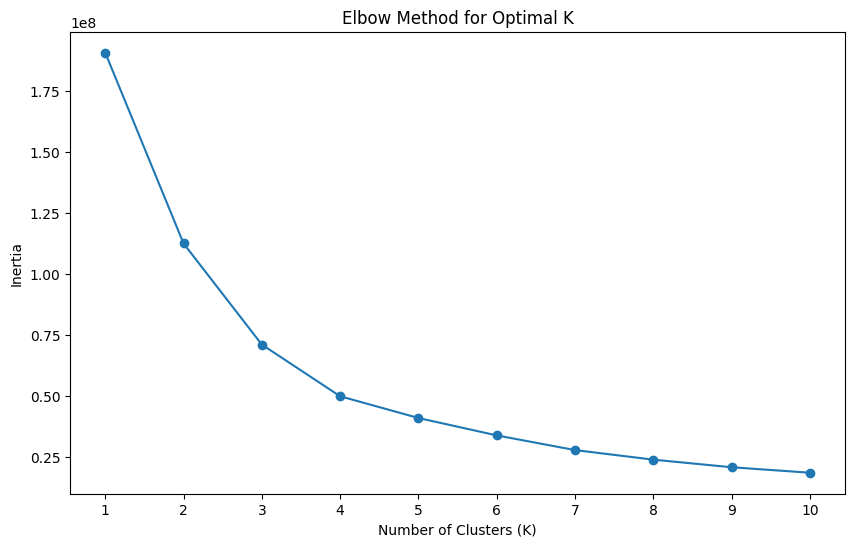

In [59]:
inertia = []
for k in range(1, 11):  # 1부터 10까지 클러스터 개수 시도
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df['2dim'].tolist())
    inertia.append(kmeans.inertia_)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(range(1, 11))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


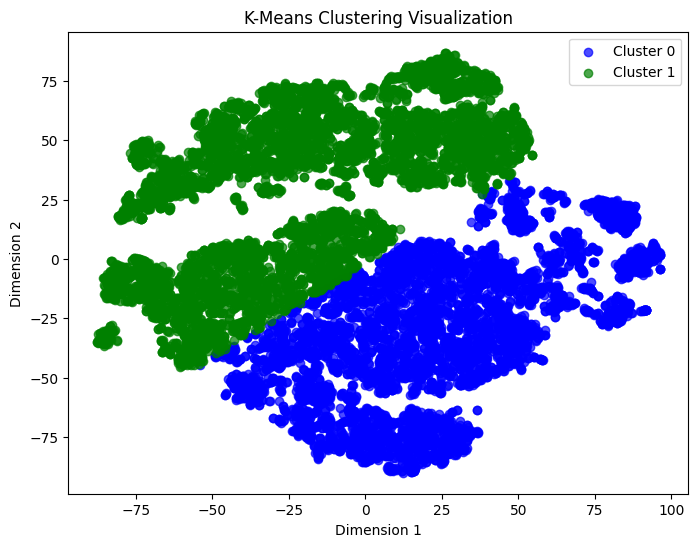

In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터프레임 생성 (임의의 데이터 예시)
# df['2dim']에 개별 기사들의 임베딩 정보가 들어있다고 가정합니다.

# K-Means 군집화 수행
n_clusters = 2 # 최적의 K 값으로 지정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df['2dim'].tolist())

# 2D 시각화를 위한 코드
plt.figure(figsize=(8, 6))

# 각 군집별로 점을 다른 색으로 표시
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FF5733', '#33FF99', '#663399', '#FFFF66', '#990000',
          '#009999', '#FFCC33', '#336633', '#660066', '#993333', '#6666FF', '#FF99CC', '#FF6699']
for i in range(n_clusters):
    cluster_points = df[df['cluster'] == i]
    plt.scatter(cluster_points['2dim'].apply(lambda x: x[0]), cluster_points['2dim'].apply(lambda x: x[1]),
                c=colors[i], label=f'Cluster {i}', alpha=0.7)

# 시각화 설정
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('K-Means Clustering Visualization')
plt.legend()
plt.show()

In [29]:
from scipy.spatial.distance import cdist
cluster_means = df.groupby('cluster')[['embedding_x', 'embedding_y']].mean()

def find_closest_rows_to_mean(cluster_mean, cluster_data, num_closest=2):
    distances = cdist([cluster_mean], cluster_data).squeeze()
    closest_row_indices = np.argsort(distances)[:num_closest]
    return closest_row_indices

# 클러스터별 평균 계산
cluster_means = df.groupby('cluster')[['embedding_x', 'embedding_y']].mean()

# 결과를 저장할 리스트 초기화
closest_row_indices = []

# 각 클러스터에 대해 가장 가까운 두 개의 행 찾기
for cluster_id, cluster_mean in cluster_means.iterrows():
    cluster_data = df[df['cluster'] == cluster_id][['embedding_x', 'embedding_y']].values
    closest_indices = find_closest_rows_to_mean(cluster_mean, cluster_data, num_closest=2)
    closest_row_indices.extend([(cluster_id, idx) for idx in closest_indices])

# 결과 출력
for cluster_id, closest_index in closest_row_indices:
    print(f"Cluster {cluster_id}: Closest row index - {closest_index}")

Cluster 0: Closest row index - 1863
Cluster 0: Closest row index - 1853
Cluster 1: Closest row index - 1493
Cluster 1: Closest row index - 3131
Cluster 2: Closest row index - 2016
Cluster 2: Closest row index - 2926
Cluster 3: Closest row index - 1016
Cluster 3: Closest row index - 974
Cluster 4: Closest row index - 21
Cluster 4: Closest row index - 1005
Cluster 5: Closest row index - 3192
Cluster 5: Closest row index - 2668
Cluster 6: Closest row index - 1595
Cluster 6: Closest row index - 9


/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_4174/3749622649.py:15: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_4174/3749622649.py:15: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_4174/3749622649.py:15: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_4174/3749622649.py:15: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_4174/3749622649.py:15: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/var/folders/qh/w78sz3hn2f74vt85lstkxs

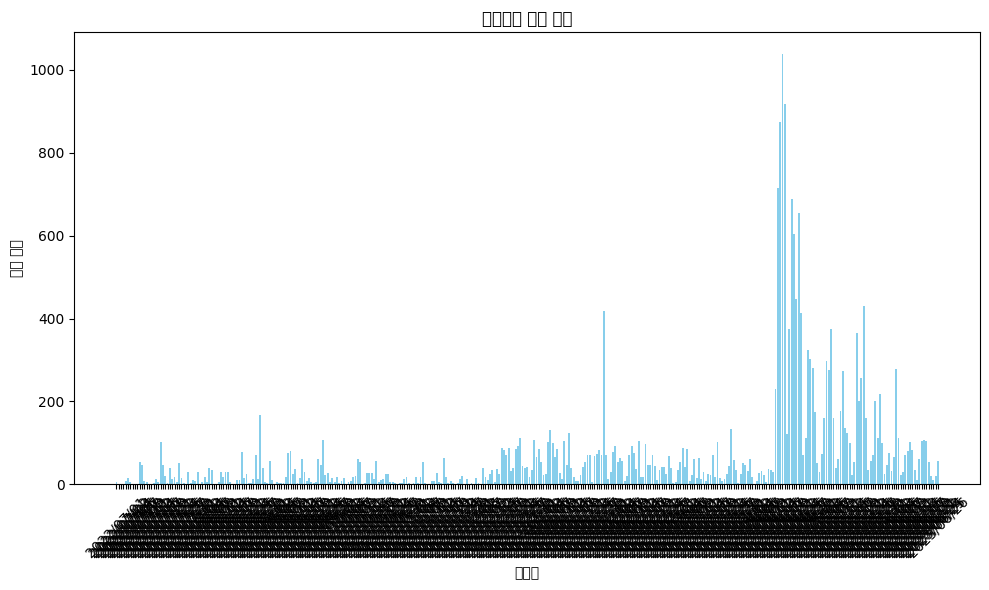

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# 작성일 열을 기준으로 행의 개수를 계산하여 새로운 데이터프레임 생성
daily_counts = df['작성일'].value_counts().sort_index().reset_index()
daily_counts.columns = ['작성일', '행의 개수']

plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.bar(daily_counts['작성일'], daily_counts['행의 개수'], color='skyblue')
plt.xlabel('작성일')
plt.ylabel('행의 개수')
plt.title('작성일별 행의 개수')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


In [40]:
df = pd.read_json('beta3.json')
df

,작성일,작성자,제목,내용,sliced,embedding,2dim,embedding_x,embedding_y
0,2023/05/10,YTN,"인천 전세사기 사건, 수사 역량과 현재 진행 상황은?","■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12:...","[■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12...","[0.2633713186, 0.1695501804, -0.0619390905, -0...","[-75.3090515137, 21.6782989502]",-75.309052,21.678299
1,2023/06/08,연합뉴스TV,[뉴스포커스] 이달중 전세사기 피해자 첫 결정…오늘 특별단속 결과 발표,<출연 : 임주혜 변호사> 정부가 지난 1일 전세사기 피해지원 특별법을 시행한 이후...,[<출연 : 임주혜 변호사> 정부가 지난 1일 전세사기 피해지원 특별법을 시행한 이...,"[0.2683984935, 0.048945155000000004, -0.012165...","[-71.8215637207, 29.4318332672]",-71.821564,29.431833
2,2023/05/02,경향신문,[단독]“임대인이 ‘ㄱㅇㅎ’인 전세사기 피해자 찾습니다”,인천 미추홀구 전세사기 피해자 A씨는 지난달 27일 정부의 전세사기 피해자 지원대책...,[인천 미추홀구 전세사기 피해자 A씨는 지난달 27일 정부의 전세사기 피해자 지원대...,"[0.0972038284, -0.08350914720000001, -0.033970...","[-55.5996818542, -24.7295627594]",-55.599682,-24.729563
3,2023/04/27,연합뉴스,"전세사기 대책 ""늦었지만 최선의 대응""…지원대상 놓고 논란도(종합)",'사기' 여부 판단 쉽지않아…무자본 갭투자 피해자 등과 형평성 문제 빌라 등 역전세...,['사기' 여부 판단 쉽지않아…무자본 갭투자 피해자 등과 형평성 문제 빌라 등 역전...,"[0.14349778, -0.21786880490000002, 0.121255621...","[-56.176612854, -1.2880284786]",-56.176613,-1.288028
4,2023/05/10,뉴스1,“전세사기 예견됐던 일…정권 아닌 국민 위한 부동산 정책 절실”,"대전시-공인중개사협회 대전시지부, 방지대책 위한 합동회의 참석자 이구동성 정부·언론...","[대전시-공인중개사협회 대전시지부, 방지대책 위한 합동회의 참석자 이구동성 정부·언...","[0.2650913298, -0.0386504531, -0.0301528927, -...","[-34.5740356445, -28.9104728699]",-34.574036,-28.910473
...,...,...,...,...,...,...,...,...,...
12430,2022/07/04,KBS,월세 끼고 산 집에 웬 ‘전세 세입자’…수도권·대전 피해 신고 속출,[앵커] 월세 받으려고 오피스텔에 투자하는 분들 있습니다. 월세를 끼고 샀다고 생각...,"[[앵커] 월세 받으려고 오피스텔에 투자하는 분들 있습니다., 월세를 끼고 샀다고 ...","[0.3382261395, 0.0455085561, -0.1426728964, -0...","[-72.4348983765, 27.9899024963]",-72.434898,27.989902
12431,2022/07/04,JTBC,여야 자리다툼에 35일 '허송세월'…민생법안 처리 '험로',극한 대치 끝에 후반기 국회의장단 선출 사개특위 구성 등 놓고 여전히 의견 차 [앵...,[극한 대치 끝에 후반기 국회의장단 선출 사개특위 구성 등 놓고 여전히 의견 차 [...,"[0.40232014660000004, -0.0497806557, -0.089859...","[-22.6246738434, 53.9219245911]",-22.624674,53.921925
12432,2022/07/02,세계일보,‘월세 대세’ 새 임대차법이 불 지피고 금리인상이 기름 부어 [심층기획],"‘전세의 월세화’ 현상 가속 임대차 거래, 이미 월세 > 전세 역전 이달말 새 임대...","[‘전세의 월세화’ 현상 가속 임대차 거래, 이미 월세 > 전세 역전 이달말 새 임...","[0.051223833100000005, -0.166622594, 0.0547159...","[-72.7276687622, -4.9536519051]",-72.727669,-4.953652
12433,2022/07/01,뉴스1,"국토부 2030 직원 모인 'MZ보드' 출범…원희룡 ""아낌없이 지원""","과도한 행정업무·평가지표 등 개선 건의…元 ""당장 모두 없앤다"" 화답 (서울=뉴스1...","[과도한 행정업무·평가지표 등 개선 건의…元 ""당장 모두 없앤다"" 화답 (서울=뉴스...","[0.1957331598, -0.0178299434, 0.10326663400000...","[-10.4386491776, -18.8570976257]",-10.438649,-18.857098


In [41]:
df['작성일'] = pd.to_datetime(df['작성일'])
df1 = df[df['작성일'] <= '2023-01-31']
df2 = df[(df['작성일'] <= '2023-04-24') & (df['작성일'] > '2023-01-31')]
df3 = df[df['작성일'] > '2023-04-24']


/Users/likeacloud/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/likeacloud/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/likeacloud/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/likeacloud/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/likeacloud/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE

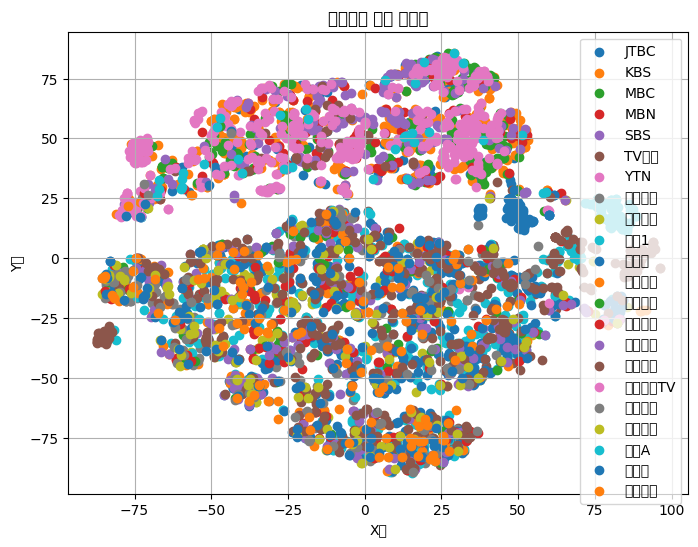

In [42]:
grouped = df3.groupby('작성자')

# 좌표평면에 점 찍기
plt.figure(figsize=(8, 6))

for name, group in grouped:
    x_vals = [x[0] for x in group['2dim']]
    y_vals = [x[1] for x in group['2dim']]
    plt.scatter(x_vals, y_vals, label=name)

plt.xlabel('X축')
plt.ylabel('Y축')
plt.title('작성자별 벡터 시각화')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
up = ['MBC', 'MBN', 'JTBC', '채널A', 'SBS' ,'KBS','연합뉴스TV' ,'YTN']
down = ['조선일보', '중앙일보','TV조선(오른쪽 아래)','한국일보', '한겨례', '세계일보', '문화일보', '국민일보', '동아일보', '서울신문', '뉴시스', '뉴스1', '연합뉴스', '경향신문']
main = ['조선일보', '중앙일보','TV조선(오른쪽 아래)','한국일보', '한겨례', '세계일보', '문화일보', '국민일보', '동아일보', '서울신문', '뉴시스', '뉴스1', '연합뉴스', '경향신문', 'MBC', 'MBN', 'JTBC', '채널A', 'SBS' ,'KBS','연합뉴스TV' ,'YTN']

In [47]:
df1 = df[df['작성자'].isin(up)]
df1.reset_index(drop=True, inplace=True)
df1

,작성일,작성자,제목,내용,sliced,embedding,2dim,embedding_x,embedding_y
0,2023-05-10,YTN,"인천 전세사기 사건, 수사 역량과 현재 진행 상황은?","■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12:...","[■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12...","[0.2633713186, 0.1695501804, -0.0619390905, -0...","[-75.3090515137, 21.6782989502]",-75.309052,21.678299
1,2023-06-08,연합뉴스TV,[뉴스포커스] 이달중 전세사기 피해자 첫 결정…오늘 특별단속 결과 발표,<출연 : 임주혜 변호사> 정부가 지난 1일 전세사기 피해지원 특별법을 시행한 이후...,[<출연 : 임주혜 변호사> 정부가 지난 1일 전세사기 피해지원 특별법을 시행한 이...,"[0.2683984935, 0.048945155000000004, -0.012165...","[-71.8215637207, 29.4318332672]",-71.821564,29.431833
2,2023-05-08,YTN,왜 하필 인천 미추홀구에서 전세사기가 많이 발생했을까?,"■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12:...","[■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12...","[0.2092928439, 0.16826014220000002, -0.0349239...","[-76.0126113892, 23.024520874]",-76.012611,23.024521
3,2023-05-25,KBS,전세사기 특별법 다음달 1일 시행…피해 임차인 지원업무 가동,전세사기 피해자 지원을 위한 특별법이 다음달 1일부터 시행됩니다. 국토교통부는 25...,"[전세사기 피해자 지원을 위한 특별법이 다음달 1일부터 시행됩니다., 국토교통부는 ...","[0.3135694265, -0.0504501089, -0.0116980812, -...","[-39.0014648438, 61.1844596863]",-39.001465,61.184460
4,2023-05-09,YTN,전세사기 문제 이후 커지는 공인중개사 책임론,"■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12:...","[■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12...","[0.2561234832, 0.1673139036, 0.0352677107, -0....","[-75.7702713013, 22.5691261292]",-75.770271,22.569126
...,...,...,...,...,...,...,...,...,...
3946,2022-07-11,KBS,분양업체와 짜고 수백억 전세 사기…‘세 모녀’ 추가 기소,수도권 일대에서 전세 사기로 수백억 원을 가로챈 혐의를 받는 이른바 ‘세 모녀 전세...,[수도권 일대에서 전세 사기로 수백억 원을 가로챈 혐의를 받는 이른바 ‘세 모녀 전...,"[0.44135198000000003, 0.0581511259, 0.21819983...","[13.2153377533, 80.4703598022]",13.215338,80.470360
3947,2022-07-05,JTBC,국회의장에 김진표…여야 자리다툼에 35일 '허송세월',[앵커] 국회가 어제(4일) 본회의를 열고 김진표 더불어민주당 의원을 국회의장으로 ...,[[앵커] 국회가 어제(4일) 본회의를 열고 김진표 더불어민주당 의원을 국회의장으로...,"[0.2447970659, -0.0416280478, -0.1683549881000...","[-10.0355901718, 55.9032287598]",-10.035590,55.903229
3948,2022-07-05,KBS,월세 끼고 산 집에 웬 ‘전세 세입자’…수도권·대전 피해 속출,"[앵커] 월세를 낀 오피스텔을 샀다고 생각했는데, 그 집에 전세 세입자가 살고 있다...","[[앵커] 월세를 낀 오피스텔을 샀다고 생각했는데, 그 집에 전세 세입자가 살고 있...","[0.3638673127, 0.031354833400000004, -0.086997...","[-61.7664375305, 34.3246421814]",-61.766438,34.324642
3949,2022-07-04,KBS,월세 끼고 산 집에 웬 ‘전세 세입자’…수도권·대전 피해 신고 속출,[앵커] 월세 받으려고 오피스텔에 투자하는 분들 있습니다. 월세를 끼고 샀다고 생각...,"[[앵커] 월세 받으려고 오피스텔에 투자하는 분들 있습니다., 월세를 끼고 샀다고 ...","[0.3382261395, 0.0455085561, -0.1426728964, -0...","[-72.4348983765, 27.9899024963]",-72.434898,27.989902


/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_1157/1351033757.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cluster'] = cluster_labels


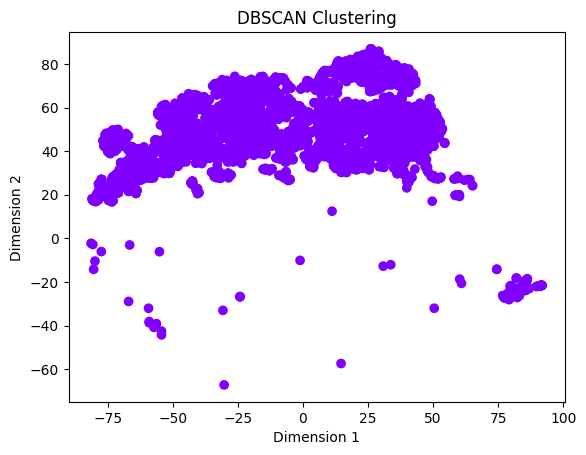

             작성일     작성자                                        제목  \
0     2023-05-10     YTN             인천 전세사기 사건, 수사 역량과 현재 진행 상황은?   
1     2023-06-08  연합뉴스TV   [뉴스포커스] 이달중 전세사기 피해자 첫 결정…오늘 특별단속 결과 발표   
2     2023-05-02    경향신문           [단독]“임대인이 ‘ㄱㅇㅎ’인 전세사기 피해자 찾습니다”   
3     2023-04-27    연합뉴스     전세사기 대책 "늦었지만 최선의 대응"…지원대상 놓고 논란도(종합)   
4     2023-05-10     뉴스1       “전세사기 예견됐던 일…정권 아닌 국민 위한 부동산 정책 절실”   
...          ...     ...                                       ...   
12430 2022-07-04     KBS     월세 끼고 산 집에 웬 ‘전세 세입자’…수도권·대전 피해 신고 속출   
12431 2022-07-04    JTBC          여야 자리다툼에 35일 '허송세월'…민생법안 처리 '험로'   
12432 2022-07-02    세계일보  ‘월세 대세’ 새 임대차법이 불 지피고 금리인상이 기름 부어 [심층기획]   
12433 2022-07-01     뉴스1    국토부 2030 직원 모인 'MZ보드' 출범…원희룡 "아낌없이 지원"   
12434 2022-07-01     뉴시스                        [신간] 우리는 투기의 민족입니다   

                                                      내용  \
0      ■ 방송 : YTN 라디오 FM 94.5 (06:47~06:57, 12:47~12:...   
1      <출연 : 임주혜 변호사> 정부가 지난 1일 전세사기 피해

In [55]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 데이터프레임 'df'의 '2dim' 열에 있는 벡터들을 가져옴
vectors = df1['2dim'].tolist()

# DBSCAN 클러스터링 모델 생성
dbscan = DBSCAN(eps=0.1, min_samples=5)  # eps: 클러스터 반경, min_samples: 클러스터에 속해야 하는 최소 데이터 수

# 클러스터 할당
cluster_labels = dbscan.fit_predict(vectors)

# 클러스터 할당 결과를 데이터프레임에 추가
df1['cluster'] = cluster_labels

# 시각화
plt.scatter(df1['2dim'].apply(lambda x: x[0]), df1['2dim'].apply(lambda x: x[1]), c=df1['cluster'], cmap='rainbow')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('DBSCAN Clustering')
plt.show()

# 클러스터 할당된 결과 출력
print(df)


# ?

In [2]:
df = pd.read_json('test1.json')
len(df)

13284

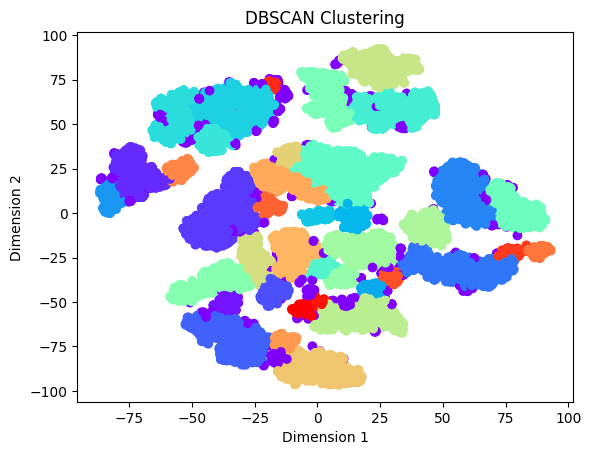

In [13]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터프레임 'df'의 '2dim' 열에 있는 벡터들을 가져옴
vectors = df['2dim'].tolist()

# 벡터 데이터를 정규화
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(vectors)

# DBSCAN 클러스터링 모델 생성
dbscan = DBSCAN(eps=0.09, min_samples=50)  # eps: 클러스터 반경, min_samples: 클러스터에 속해야 하는 최소 데이터 수

# 클러스터 할당
cluster_labels = dbscan.fit_predict(scaled_vectors)

# 클러스터 할당 결과를 데이터프레임에 추가
df['cluster'] = cluster_labels

# 시각화
plt.scatter(df['2dim'].apply(lambda x: x[0]), df['2dim'].apply(lambda x: x[1]), c=df['cluster'], cmap='rainbow')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('DBSCAN Clustering')
plt.show()

In [14]:
len(df[df['cluster'] != -1])

12731

In [15]:
df.to_json('test1.json')

In [16]:
df['cluster'].unique().max()

38

In [ ]:
ddd = [8,]
p = [] # 피해
c = [3,] # 처벌
d = [5,6,7,] # 대응 
# -> 사회적 문제의 발생~완화의 흐름 양상 확인

# 제도, 법률의 허점 파악 & 연관되어 우려되는 문제 선제적 대응 입법
b = [1,2,4,] # 비판 : 사태가 발생한 원인(임대차 3법 등 기존 제도 허점 지적) / 정치권 대응에 대한 비판(늦춰지는 것, 실효성)
e = [0,21,23] # 연관 : 깡통전세 & 역전세 이슈 우려 증가

In [331]:
a = set(list(range(31))) # 현재 전체 cluster 번호
dt = {24,27,} # 제거할 cluster 번호
w = a-dt
df1 = df[df['cluster'].isin(w)]
df1.reset_index(drop=True, inplace=True)

In [332]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df1['embedding'].tolist())

# 2차원까지 t-SNE로 차원 축소
tsne = TSNE(n_components=2, n_iter=1000)
tsne_result = tsne.fit_transform(pca_result)
df1['2dim'] = tsne_result.tolist()
df1[['embedding_x', 'embedding_y']] = pd.DataFrame(df1['2dim'].tolist(), index=df1.index)

/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_1606/1976878840.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['2dim'] = tsne_result.tolist()
/var/folders/qh/w78sz3hn2f74vt85lstkxs640000gn/T/ipykernel_1606/1976878840.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['embedding_x', 'embedding_y']] = pd.DataFrame(df1['2dim'].tolist(), index=df1.index)


In [333]:
df1.to_json('test1.json')